In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
warnings.filterwarnings('ignore')

2023-09-26 00:40:36.170285: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 00:40:36.191206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 00:40:36.518621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/libpysal/examples/remotes.py:24: UserWarning:

Remote data sets not available. Check connection.



## Load the data

In [2]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/germband_models"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [3]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germband_v2.h5ad")
germ_pc = st.tdr.read_model(f"pc_models/Germband_{sample_id}_aligned_pc_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 20424 × 8136
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes'
    uns: 'glm_degs', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

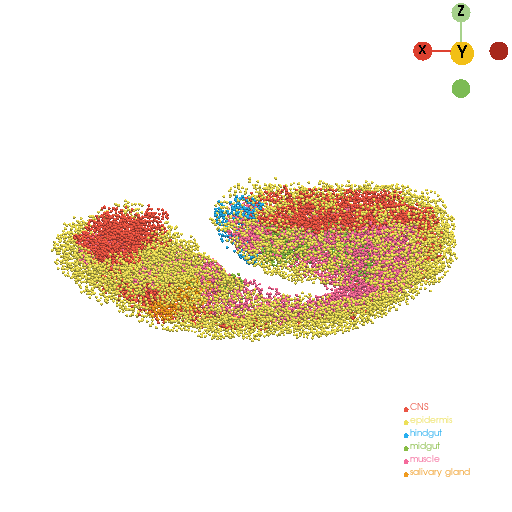

In [4]:
st.pl.three_d_plot(
    model=germ_pc,
    key="tissue",
    model_style="points",
    cpo=cpo,
    jupyter="static",
)

In [5]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

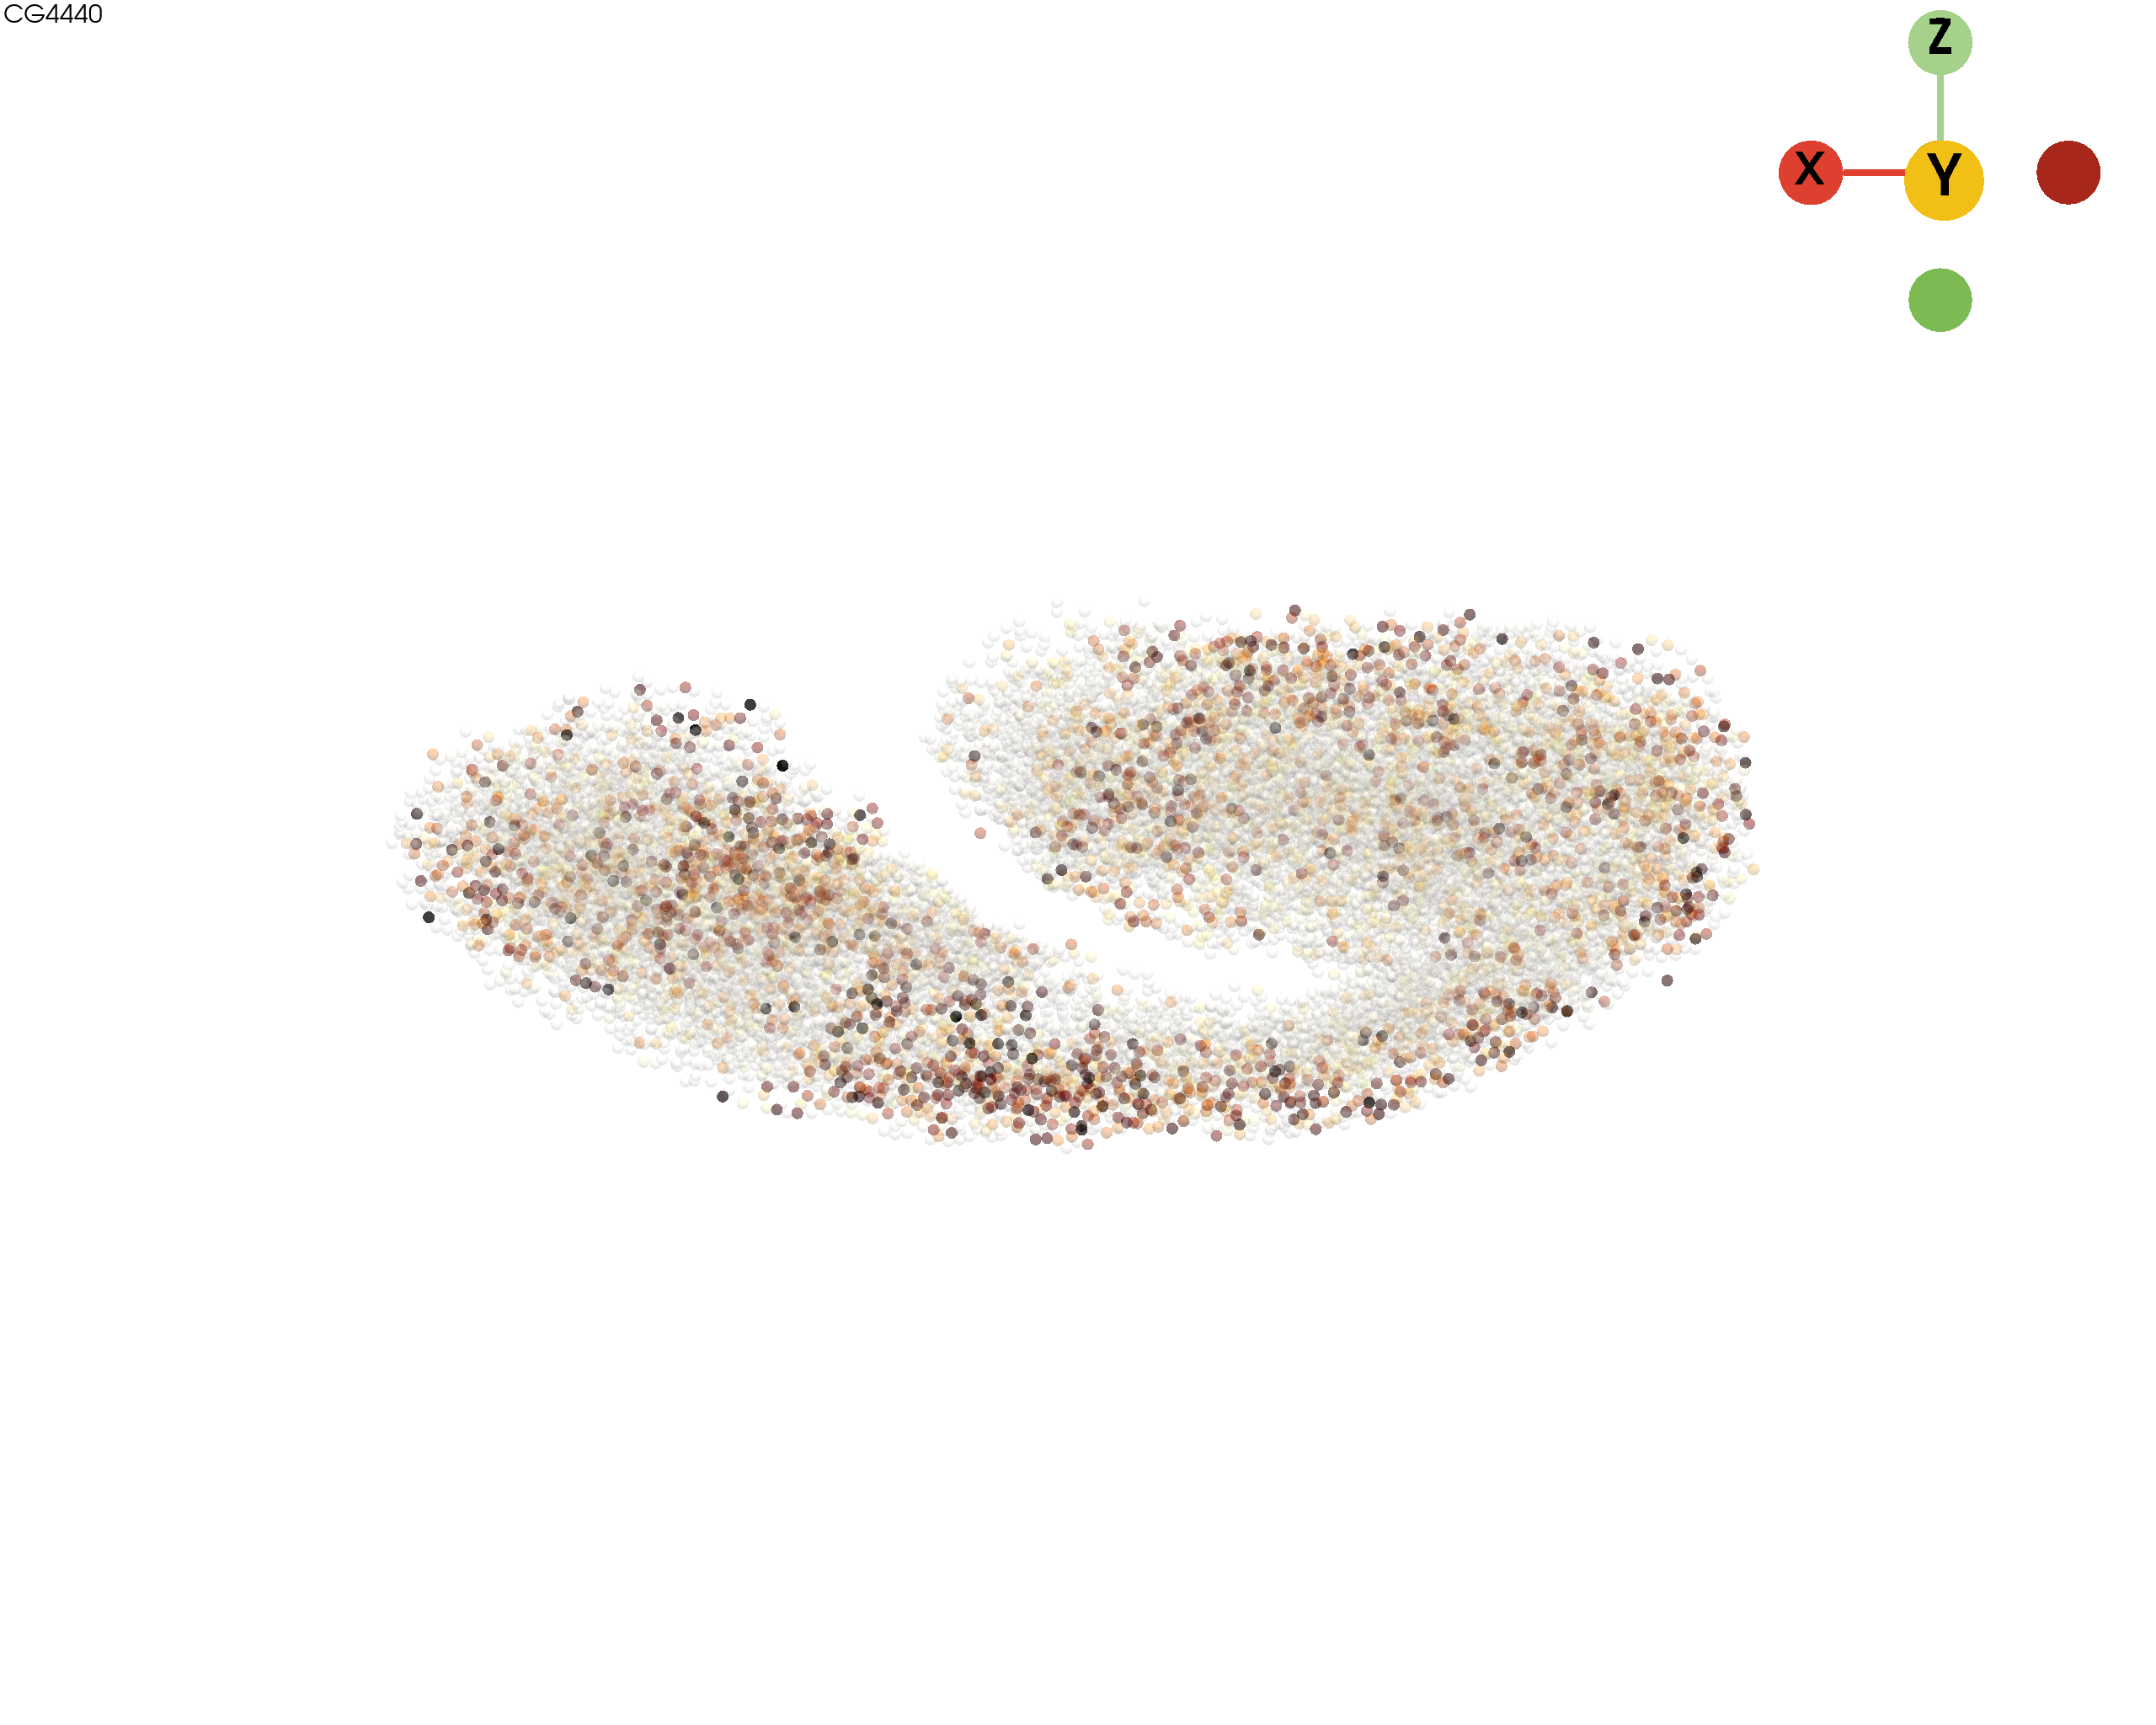

In [9]:
germ_adata.X= germ_adata.layers["X_counts"].copy()
sc.pp.normalize_total(germ_adata)
sc.pp.log1p(germ_adata)
for gn in ["CG4440"]:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn

    out_image_genes = os.path.join(out_image_path, "acceleration_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)

    pc_index = germ_pc.point_data["obs_index"].tolist()
    exp = germ_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0

    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=germ_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data", inplace=True,
                     colormap="afmhot_r")

    st.pl.three_d_plot(
        model=germ_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter="static",
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
    )

## Generate mesh model

In [36]:
germ_mesh, adapt_germ_pc, _ = st.tdr.construct_surface(
    pc=germ_pc,
    key_added="tissue",
    label="Germband_shell",
    color="gainsboro",
    alpha=1,
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 0.56}, # 0.5-1.5
    smooth=4000, # 3000 - 6000
    scale_factor=1.03, # 1 - 1.05
)

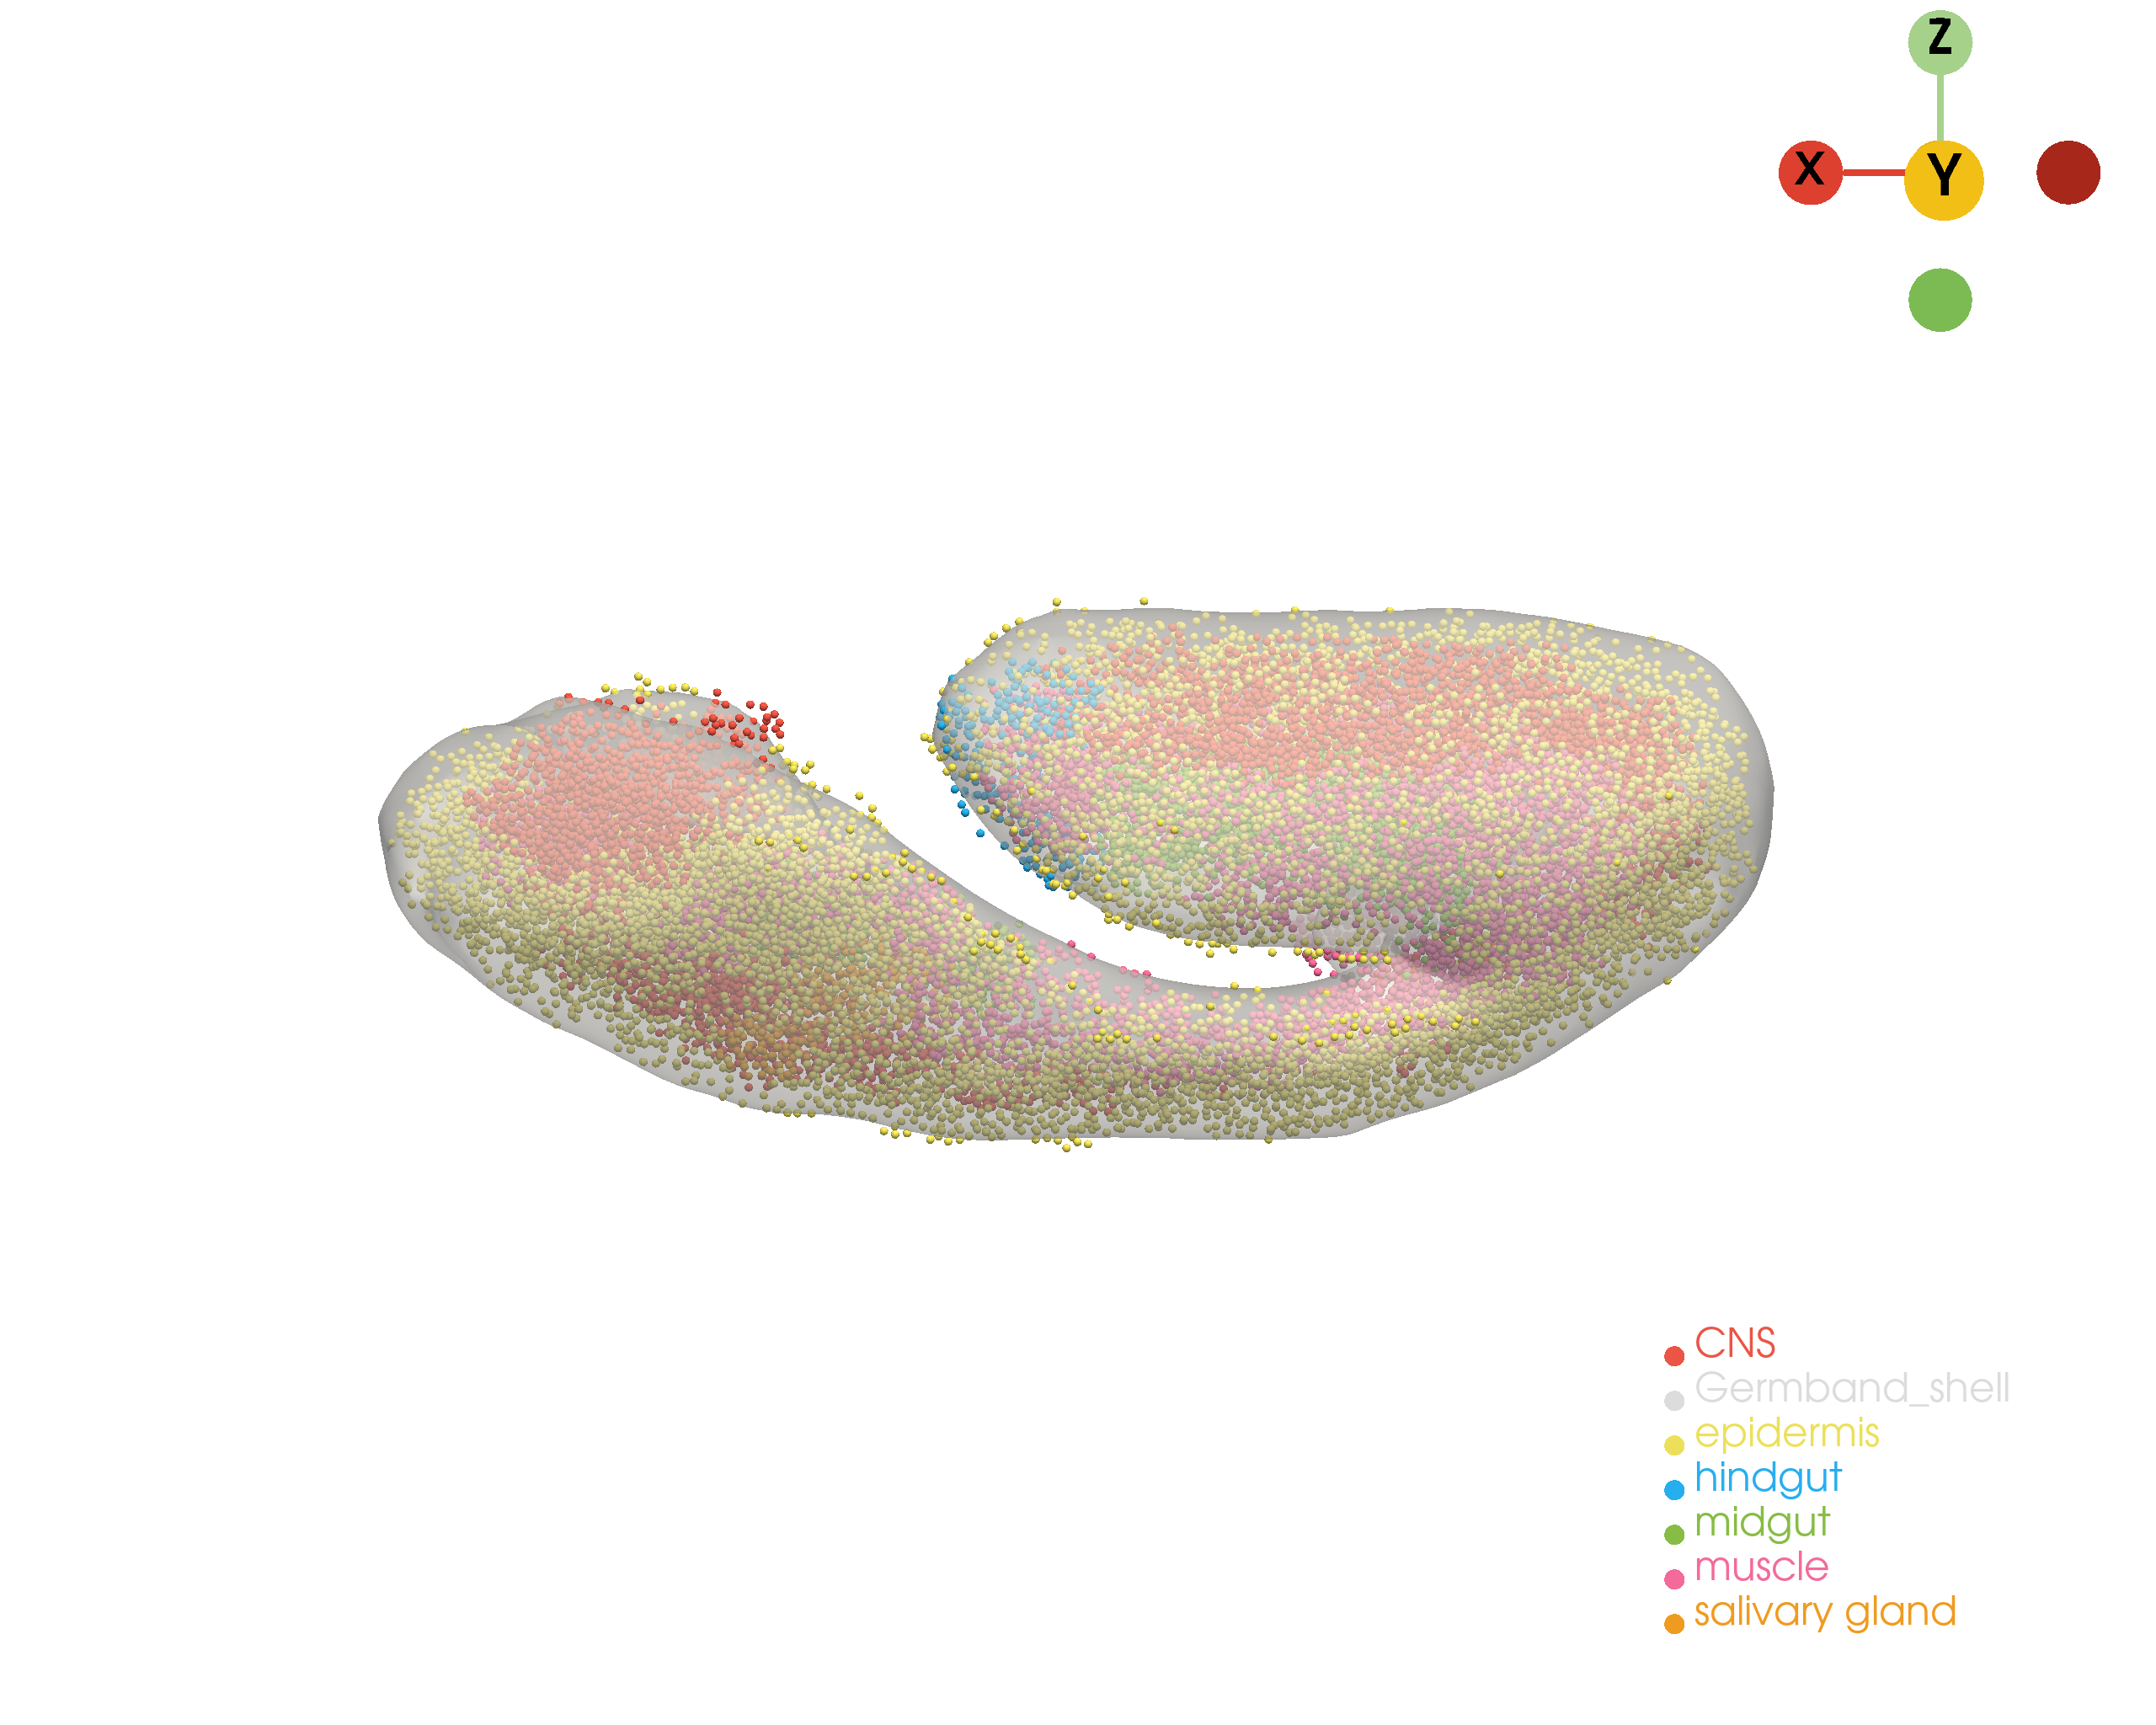

In [40]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([germ_mesh, germ_pc]),
    key="tissue",
    model_style=["surface", "points"],
    model_size=10,
    opacity=[0.6, 1],
    cpo=cpo,
    jupyter="static",
    window_size=(2560, 2048),
    #filename=os.path.join(out_image_path, f"{sample_id}_germband_mesh_model.png")
)

## embryo mesh

In [31]:
embryo_mesh = st.tdr.read_model(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}/mesh_models_new/0_Embryo_{sample_id}_aligned_mesh_model.vtk")

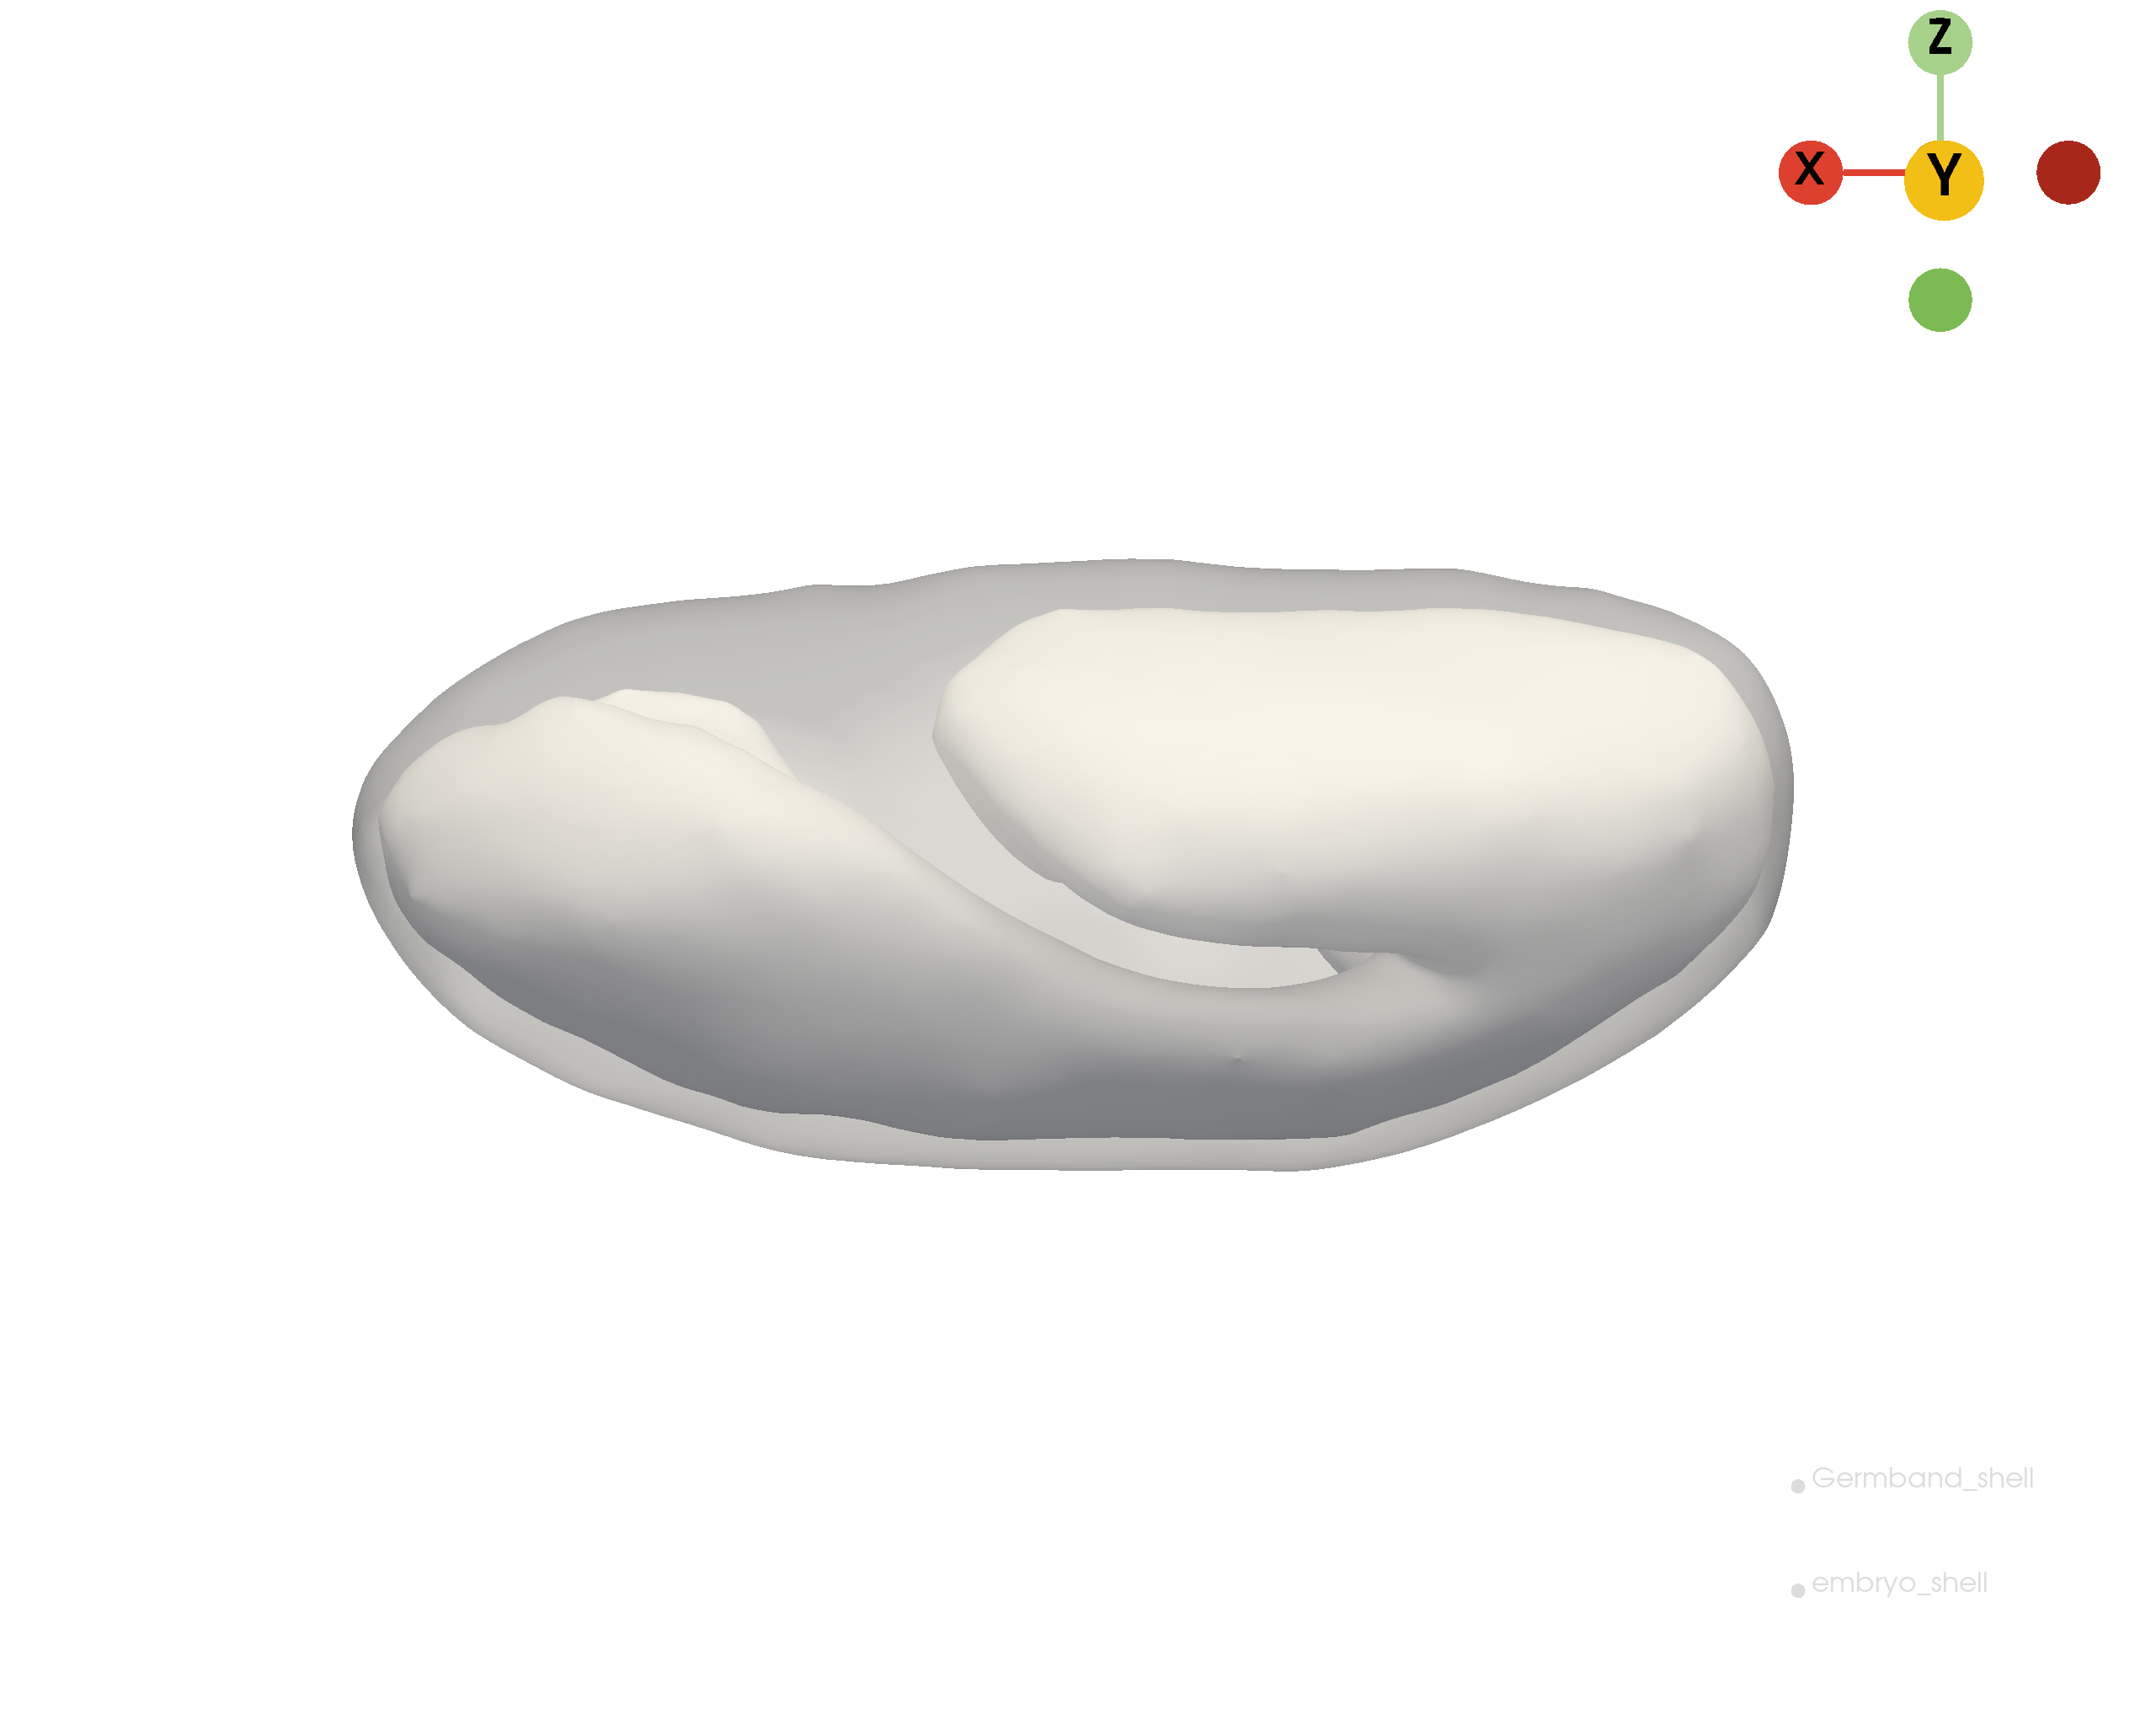

In [47]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([embryo_mesh, germ_mesh]),
    key="tissue",
    model_style="surface",
    opacity=[1, 1],
    # colormap=[None, "Spectral_r"],
    cpo=cpo,
    jupyter="static",
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_germband_mesh_model.png")
)

In [48]:
st.tdr.save_model(germ_mesh, f"mesh_models/Germband_{sample_id}_aligned_mesh_model.vtk")